In [192]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2
import cache
import scipy.spatial.distance 
import time
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

import tensorflow as tf
import tensorflow.python.platform
import prettytensor as pt

import data_manager as dm
from rect_tools import *

import inception

# Apparel Retrieval with Deep Neural Features
This notebook implements the various retrieval techniques based on Deep Neural Features.

## Getting our Data
Please refer to the repo's readme for a complete description of the data we are using.    
We collect our catalogue item and queries in dictionnaries where the key is the id present in the files names.
As we ignore some of them, id's are not continuous. What we call "class" is the corresponding number when only counting the images we kept.    
We refer to the dresses catalogue with **cat** and to the set of queries with **quer**.

`db/robes/cat/` id ignored: [26, 2, 50, 53, 89, 110, 120, 127, 131, 144, 167, 159, 190, 142]
`db/robes/mod/` id ignored: [26, 2, 50, 53, 89, 110, 120, 127, 131, 144, 167, 159, 190, 142]

The database contains 196 query/item pairs such as:
	db/robes/cat/0_0.jpg
	db/robes/mod/0.jpg

opening db/robes/cat/198_0.jpg
opening db/robes/mod/198.jpg


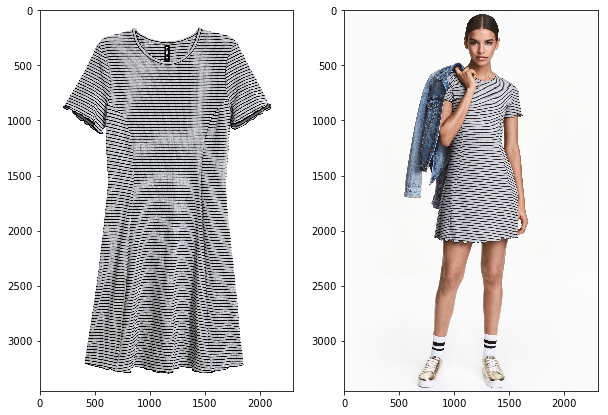

In [2]:
# some data is ill-formated, we dont want it
to_ignore_file = "to_ignore.txt"
db_path = 'db/robes/'

cat_by_id = dm.get_images_by_id(db_path+'cat/',dm.id_getter_cat,dm.id_select_cat,to_ignore_file)
quer_by_id = dm.get_images_by_id(db_path+'mod/',dm.id_getter_quer,dm.id_select_quer,to_ignore_file)

class_of_id, id_of_class = dm.get_id_class_correspondance(cat_by_id)
print("\nThe database contains "+str(len(cat_by_id))+" query/item pairs such as:\n\t"+str(cat_by_id[0])+"\n\t"+str(quer_by_id[0])+"\n")

id_img_ex = 198
img_cat_ex = dm.img_getter(cat_by_id[id_img_ex])
img_quer_ex = dm.img_getter(quer_by_id[id_img_ex])

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img_cat_ex)
plt.subplot(122)
plt.imshow(img_quer_ex)
plt.show()

## Queries Region Of Interest
We use a simple hand-crafted heuristic in order to get a ROI for the query image.

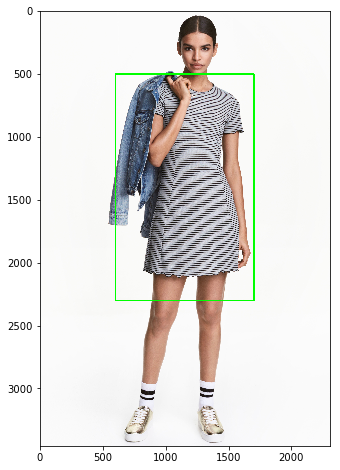

In [3]:
roi_query = (600,500,1100,1800)
img_quer_ex_roi = img_quer_ex.copy()
draw_rectangle(img_quer_ex,roi_query,(0,255,0),thick=10)

plt.figure(figsize = (8,8))
plt.imshow(img_quer_ex)
plt.show()

## Images Sub-Sampling
We are going to sample the ROI (or entire image) at fixed scale and strides.   
We call the sub images rectangle *crops*.    
We do it with squared sliding windows (rectangles at borders).

In [4]:
# returns the list with all the samples rect ('crops')
# img: image to crop from
# roi: rectangle to sample
# divide_by: divide minimum side by divide_by (integer)
# stride: will move in minimum_side / divide_by unit
def regular_sampling(img, roi, divide_by, stride):
    if not le_pt(stride,(1.,1.)):
        print("error: stride should be <= 1.")
        return []
    
    all_crops = []
    unit_square_sz = min(roi[2:])/divide_by
    
    x_range = np.arange(roi[0], roi[0]+roi[2],unit_square_sz*stride[0])
    y_range = np.arange(roi[1], roi[1]+roi[3],unit_square_sz*stride[1])
    
    # for integer redundancy
    seen_crops = {}
    
    for y in y_range:
        for x in x_range:
            integer_crop = (int(x),int(y),int(unit_square_sz),int(unit_square_sz))
            
            # get rid of out ranged ones
            if not valid_rect(roi,integer_crop):
                continue
            
            if integer_crop in seen_crops:
                print("warning: integer redundancy in crops")
            seen_crops[integer_crop] = True
            
            all_crops.append(integer_crop)
    return eat_it_all(all_crops,roi)

# the above function could leave a small percentage of the roi untouched
# this fixes it (not really optimally though)
def eat_it_all(crop_list, roi):
    max_x = max([crop[0] for crop in crop_list])
    max_y = max([crop[1] for crop in crop_list])
    
    right_bot = get_end_point(roi)
    
    new_list = []
    for x,y,w,h in crop_list:
        new_x,new_y,new_w,new_h=x,y,w,h
        if x == max_x and x+w < right_bot[0]:
            new_w = right_bot[0]-x
        if y == max_y and y+h < right_bot[1]:
            new_h = right_bot[1]-y
        new_list.append((new_x,new_y,new_w,new_h))
    return new_list

### Example

There are 77 crops on the catalogue image


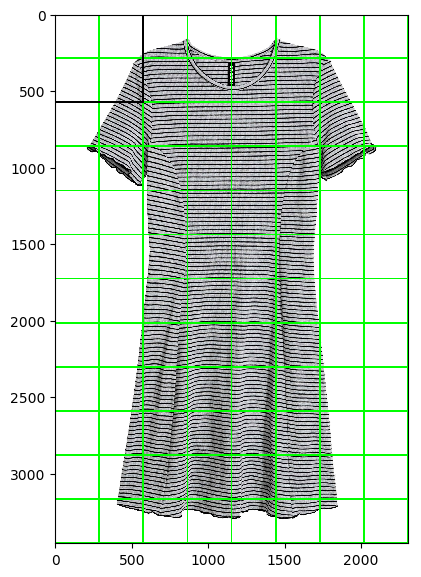

There are 84 crops on the query image


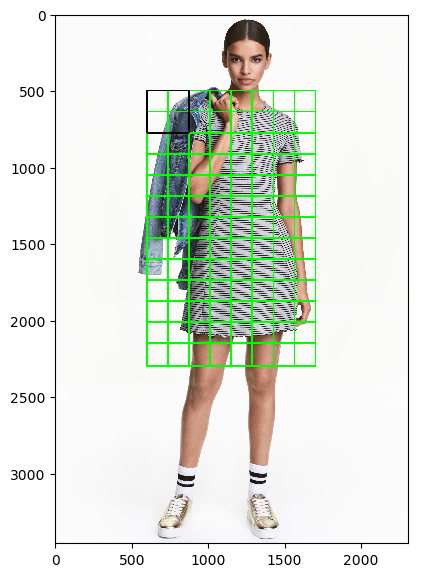

In [5]:
'''
    Plotting routine for our crops.
'''
def plot_img_samples(img,img_crops):
    fig, axes = plt.subplots(1, 1)
    fig.set_dpi(100)
    fig.set_size_inches((8,7))
    img_copy = img.copy()
    for (i,crop) in enumerate(img_crops):
        color = (255,0,0,50) if i%2 == 0 else (0,255,0,50)
        draw_rectangle(img_copy,crop,(0,255,0,50),thick=10)
    
    draw_rectangle(img_copy,img_crops[0],(0,0,0,50),thick=10)
    plt.imshow(img_copy)
    plt.show()
    img_copy = cv2.cvtColor(img_copy, cv2.COLOR_RGB2BGR)
    cv2.imwrite("ex_mod_win.jpg",img_copy)
    
img_cat_crops = regular_sampling(img_cat_ex,get_rect_img(img_cat_ex),4,(0.5,0.5))
print("There are", len(img_cat_crops), "crops on the catalogue image")
plot_img_samples(img_cat_ex,img_cat_crops)

img_quer_crops = regular_sampling(img_quer_ex,roi_query,4,(0.5,0.5))
print("There are", len(img_quer_crops), "crops on the query image")
plot_img_samples(img_quer_ex,img_quer_crops)

## Features Extraction
We use the incetionV3 model as a feature extractor.    
With the `inception` module, we use some code of [this](https://github.com/Hvass-Labs/TensorFlow-Tutorials) excellent github repo.

In [6]:
inception.maybe_download()
model = inception.Inception()

Data has apparently already been downloaded and unpacked.


In [7]:
'''
    This routine extracts all the features given an image and sub-images crops.
'''
def get_features_of_crops(img,crop_list):
    features_list = []
    for x,y,w,h in crop_list:
        img_crop = img[y:y+h,x:x+w,:]
        features = model.transfer_values(image=img_crop)
        features_list.append(features)
    return features_list

'''
    This routine creates a dictionary with the crops features associated to each garment.
    cat: a boolean that specifies whether we are working on the catalogue or the 
    queries for ROI purpose.
'''
def compute_DCNN_features(cat=True):
    to_return = {}
    
    img_set = cat_by_id
    if not cat:
        img_set = quer_by_id
    
    for (image_id,image_path) in img_set.items():
        img = dm.img_getter(image_path)
        
        img_roi = get_rect_img(img)#take all the img by default
        if not cat:
            img_roi = roi_query
        
        img_crops = regular_sampling(img,img_roi,4,(0.5,0.5))
        
        features = get_features_of_crops(img,img_crops)
        to_return[image_id] = np.array(features)

    return to_return

### Catalogue Features Extraction
We collect the features of each of the crop on each catalogue garment.
This operation would take an infinite time without GPU. It takes about 5min with GPU.

In [ ]:
cat_DCNN_per_id = cache.cache("dumps/cat_DCNN_per_id.dump",compute_DCNN_features)

In [101]:
%%time
cat_DCNN_per_id = compute_DCNN_features()

opening db/robes/cat/0_0.jpg
opening db/robes/cat/1_0.jpg
opening db/robes/cat/3_0.jpg
...
opening db/robes/cat/208_0.jpg
opening db/robes/cat/209_0.jpg
CPU times: user 6min 10s, sys: 1min 10s, total: 7min 20s
Wall time: 5min 32s


For instance here's 1 of the extracted features on our example catalogue image:

In [9]:
print(cat_DCNN_per_id[id_img_ex][0])

[ 0.27778751  0.37307236  0.06277721 ...,  0.73724282  0.54981208
  0.18307015]


We can visualize this feature vector a bit more:

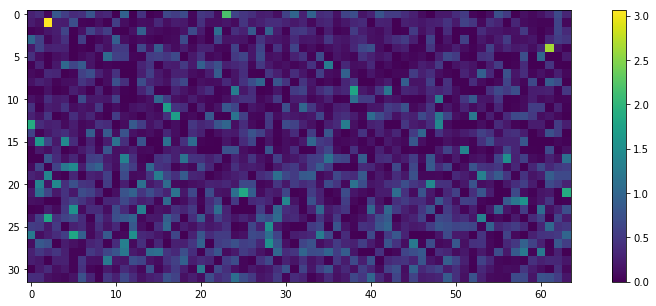

In [10]:
plt.figure(figsize=(15,5))
im = plt.imshow(cat_DCNN_per_id[id_img_ex][0].reshape((2**5,2**6)))
plt.colorbar(im)
plt.show()

For more on feature visualization please refer to THIS.

### Numpy Matrix
We aggregate our features in a big matrix:

In [11]:
cat_DCNN_np = cat_DCNN_per_id[0]
id_of_row = [0]*len(cat_DCNN_per_id[0])
for id_img,_ in cat_by_id.items():
    if id_img == 0:
        continue
    cat_DCNN_np = np.r_[cat_DCNN_np, cat_DCNN_per_id[id_img]]
    id_of_row += [id_img]*len(cat_DCNN_per_id[id_img])
cat_DCNN_np = np.array(cat_DCNN_np)
print(cat_DCNN_np.shape)
print(len(id_of_row))

(15092, 2048)
15092


# Image Retrieval
## Getting Query Features
We compute the queries' features. It takes about 5min when not dumped.

In [ ]:
quer_DCNN_per_id = cache.cache("dumps/quer_DCNN_per_id.dump",compute_DCNN_features,cat=False)

In [102]:
%%time
quer_DCNN_per_id = compute_DCNN_features(cat=False)

opening db/robes/mod/0.jpg
opening db/robes/mod/1.jpg
opening db/robes/mod/3.jpg
...
opening db/robes/mod/208.jpg
opening db/robes/mod/209.jpg
CPU times: user 6min 20s, sys: 1min 20s, total: 7min 41s
Wall time: 5min 45s


## Nearest Neighbour and Majority Vote
We treat the features of the catalogue images as one big set. For each query, for each feature vector, we find its nearest neighbour's class in the catalogue and then perform majority vote on all the query's feature vectors.

In [103]:
%%time
k_accuracy = [1,3,5,10]
success_k = np.zeros(len(k_accuracy))
time_per_query = []
best_matches = NearestNeighbors(n_neighbors=1,n_jobs=13).fit(cat_DCNN_np)
for id_quer in quer_DCNN_per_id:
    t = time.time()
    distances,indices = best_matches.kneighbors(quer_DCNN_per_id[id_quer])
    id_list = [id_of_row[i_r[0]] for i_r in indices]
    sorted_result = np.argsort(np.bincount(id_list))[::-1][:10]
    for i,k in enumerate(k_accuracy):
        success_k[i] += id_quer in sorted_result[:k]
    time_per_query.append(time.time()-t)
success_k /= len(quer_DCNN_per_id)
for i,k in enumerate(k_accuracy):
    print(str(k)+"-accuracy score:",success_k[i])
print("mean time per request:",str(np.array(time_per_query).mean())+"s")

1-accuracy score: 0.530612244898
3-accuracy score: 0.724489795918
5-accuracy score: 0.775510204082
10-accuracy score: 0.841836734694
mean time per request: 0.700636223871s
CPU times: user 24min 37s, sys: 1.31 s, total: 24min 38s
Wall time: 2min 19s


## Memory Vector and Nearest Neighbour
For each image, we aggregate its feature vectors in a memory vector and then perform 10-NN retrieval.
### Sum-Memory Vector

In [71]:
def get_sum_mv(set_of_vectors):
    return set_of_vectors.sum(axis=0)

In [74]:
cat_mv_np = []
for id_ in cat_DCNN_per_id:
    cat_mv_np.append(get_sum_mv(cat_DCNN_per_id[id_]))
cat_mv_np = np.array(cat_mv_np)

In [79]:
%%time
k_accuracy = [1,3,5,10]
success_k = np.zeros(len(k_accuracy))
time_per_query = []
ten_NN = NearestNeighbors(n_neighbors=10,n_jobs=13).fit(cat_mv_np)
for id_quer in quer_DCNN_per_id:
    t = time.time()
    quer_mv = get_sum_mv(quer_DCNN_per_id[id_quer])
    distances,indices = ten_NN.kneighbors([quer_mv])
    for i,k in enumerate(k_accuracy):
        success_k[i] += class_of_id[id_quer] in indices[0][:k]
    time_per_query.append(time.time()-t)
success_k /= len(quer_DCNN_per_id)
for i,k in enumerate(k_accuracy):
    print(str(k)+"-accuracy score:",success_k[i])
print("mean time per request:",str(np.array(time_per_query).mean())+"s")

1-accuracy score: 0.510204081633
3-accuracy score: 0.637755102041
5-accuracy score: 0.709183673469
10-accuracy score: 0.795918367347
mean time per request: 0.104297970022s
CPU times: user 1.89 s, sys: 1.54 s, total: 3.43 s
Wall time: 20.5 s


## Neural Network
We train an fully-connected, 1024-hidden units softmax ANN on our data.     
First we get our label in a one-hot style matrix:

In [12]:
def get_one_hot(x,num_classes):
    hot = np.zeros(num_classes)
    hot[x] = 1.0
    return hot


cls_one_hot_matrix = []
for id_ in id_of_row:
    cls_one_hot_matrix.append(get_one_hot(class_of_id[id_],len(cat_by_id)))
cls_one_hot_matrix = np.array(cls_one_hot_matrix)
print(cls_one_hot_matrix.shape)

(15092, 196)


Then we construct the computational graph of the model, according to this excellent github [repo](https://github.com/Hvass-Labs/TensorFlow-Tutorials):

In [22]:
transfer_len = model.transfer_len
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')
num_classes = len(cat_by_id)
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)
# Wrap the transfer-values as a Pretty Tensor object.
x_pretty = pt.wrap(x)

with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        fully_connected(size=1024, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)


global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step)

y_pred_cls = tf.argmax(y_pred, dimension=1)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [40]:
## Run this cell only if you had a pre-running tf session
session.close()

In [41]:
session = tf.Session()
session.run(tf.global_variables_initializer())

train_batch_size = 64

In [19]:
def random_batch():
    # Number of images (transfer-values) in the training-set.
    num_images = len(cat_DCNN_np)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)

    # Use the random index to select random x and y-values.
    # We use the transfer-values instead of images as x-values.
    #print(idx)
    x_batch = cat_DCNN_np[idx]
    y_batch = cls_one_hot_matrix[idx]

    return x_batch, y_batch

In [16]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images (transfer-values) and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

In [42]:
%%time
optimize(num_iterations=10000)

Global Step:    100, Training Batch Accuracy:  26.6%
Global Step:    200, Training Batch Accuracy:  42.2%
Global Step:    300, Training Batch Accuracy:  43.8%
Global Step:    400, Training Batch Accuracy:  64.1%
...
Global Step:   9800, Training Batch Accuracy:  95.3%
Global Step:   9900, Training Batch Accuracy:  90.6%
Global Step:  10000, Training Batch Accuracy:  89.1%
CPU times: user 40.7 s, sys: 3.86 s, total: 44.6 s
Wall time: 29 s


Saving the neural network we learnt:

In [31]:
saver=tf.train.Saver()
saver.save(session,"models/cat_DCNN_trained_fc.dump")

'models/cat_DCNN_trained_fc.dump'

### Majority Vote

In [100]:
k_accuracy = [1,3,5,10]
success_k = np.zeros(len(k_accuracy))
time_per_query = []
for id_quer in quer_DCNN_per_id:
    t = time.time()
    quer_features = quer_DCNN_per_id[id_quer]
    feed_dict = {x: np.array(quer_features),
             y_true: np.array([get_one_hot(0,num_classes)])}
    cls_predicted = session.run(y_pred_cls, feed_dict=feed_dict)
    sorted_result = np.argsort(np.bincount(cls_predicted))[::-1][:10]
    for i,k in enumerate(k_accuracy):
        success_k[i] += class_of_id[id_quer] in sorted_result[:k]
    time_per_query.append(time.time()-t)
success_k /= len(quer_DCNN_per_id)
for i,k in enumerate(k_accuracy):
    print(str(k)+"-accuracy score:",success_k[i])
print("mean time per request:",str(np.array(time_per_query).mean())+"s")

1-accuracy score: 0.602040816327
3-accuracy score: 0.744897959184
5-accuracy score: 0.801020408163
10-accuracy score: 0.867346938776
mean time per request: 0.00192003469078s


### Mean Probability

In [103]:
k_accuracy = [1,3,5,10]
success_k = np.zeros(len(k_accuracy))
time_per_query = []
for id_quer in quer_DCNN_per_id:
    t = time.time()
    quer_features = quer_DCNN_per_id[id_quer]
    feed_dict = {x: np.array(quer_features),
             y_true: np.array([get_one_hot(0,num_classes)])}
    all_prob = session.run(y_pred, feed_dict=feed_dict)
    all_prob_mean = all_prob.mean(axis=0)
    all_prob_sorted = all_prob_mean.argsort()[::-1]
    #print(all_prob_sorted)
    for i,k in enumerate(k_accuracy):
        success_k[i] += class_of_id[id_quer] in all_prob_sorted[:k]
    time_per_query.append(time.time()-t)
success_k /= len(quer_DCNN_per_id)
for i,k in enumerate(k_accuracy):
    print(str(k)+"-accuracy score:",success_k[i])
print("mean time per request:",str(np.array(time_per_query).mean())+"s")

1-accuracy score: 0.612244897959
3-accuracy score: 0.755102040816
5-accuracy score: 0.821428571429
10-accuracy score: 0.887755102041
mean time per request: 0.00195155338365s


## Random Forests

In [46]:
from sklearn.ensemble import RandomForestClassifier

In [47]:
cls_of_row = [class_of_id[id_] for id_ in id_of_row]

In [57]:
%%time
clf = RandomForestClassifier(n_jobs=13)
clf.fit(cat_DCNN_np,cls_of_row)

CPU times: user 1min 7s, sys: 0 ns, total: 1min 7s
Wall time: 7.97 s


### Majority Vote

In [58]:
%%time
k_accuracy = [1,3,5,10]
success_k = np.zeros(len(k_accuracy))
time_per_query = []
best_matches = NearestNeighbors(n_neighbors=1,n_jobs=13).fit(cat_DCNN_np)
for id_quer in quer_DCNN_per_id:
    t = time.time()
    cls_predicted = clf.predict(quer_DCNN_per_id[id_quer])
    sorted_result = np.argsort(np.bincount(cls_predicted))[::-1][:10]
    for i,k in enumerate(k_accuracy):
        success_k[i] += class_of_id[id_quer] in sorted_result[:k]
    time_per_query.append(time.time()-t)
success_k /= len(quer_DCNN_per_id)
for i,k in enumerate(k_accuracy):
    print(str(k)+"-accuracy score:",success_k[i])
print("mean time per request:",str(np.array(time_per_query).mean())+"s")

1-accuracy score: 0.408163265306
3-accuracy score: 0.515306122449
5-accuracy score: 0.571428571429
10-accuracy score: 0.688775510204
mean time per request: 0.104027844205s
CPU times: user 4.72 s, sys: 0 ns, total: 4.72 s
Wall time: 22.7 s


### Mean Probability

In [59]:
%%time
k_accuracy = [1,3,5,10]
success_k = np.zeros(len(k_accuracy))
time_per_query = []
best_matches = NearestNeighbors(n_neighbors=1,n_jobs=13).fit(cat_DCNN_np)
for id_quer in quer_DCNN_per_id:
    t = time.time()
    predicted_proba = clf.predict_proba(quer_DCNN_per_id[id_quer])
    mean_vec = predicted_proba.mean(axis=0)
    sorted_result = np.argsort(mean_vec)[::-1]
    for i,k in enumerate(k_accuracy):
        success_k[i] += class_of_id[id_quer] in sorted_result[:k]
    time_per_query.append(time.time()-t)
success_k /= len(quer_DCNN_per_id)
for i,k in enumerate(k_accuracy):
    print(str(k)+"-accuracy score:",success_k[i])
print("mean time per request:",str(np.array(time_per_query).mean())+"s")

1-accuracy score: 0.494897959184
3-accuracy score: 0.673469387755
5-accuracy score: 0.760204081633
10-accuracy score: 0.84693877551
mean time per request: 0.104082564918s
CPU times: user 5.58 s, sys: 1.04 s, total: 6.62 s
Wall time: 22.7 s


## Error Analysis
We analyse the source of error with our best model so far: the neural network with avg probabilities.

In [194]:
errors_id_rank = []
for id_quer in quer_DCNN_per_id:
    t = time.time()
    quer_features = quer_DCNN_per_id[id_quer]
    feed_dict = {x: np.array(quer_features),
             y_true: np.array([get_one_hot(0,num_classes)])}
    all_prob = session.run(y_pred, feed_dict=feed_dict)
    all_prob_mean = all_prob.mean(axis=0)
    all_prob_sorted = all_prob_mean.argsort()[::-1]
    
    if not class_of_id[id_quer] in all_prob_sorted[:10]:
        errors_id_rank.append((id_quer,np.argwhere(all_prob_sorted==class_of_id[id_quer])[0][0]+1))
print("errors id, retrieval rank and best match:", errors_id_rank)

errors id, retrieval rank and best match: [(1, 11), (3, 44), (7, 35), (25, 19), (30, 17), (43, 15), (65, 48), (97, 21), (98, 30), (101, 14), (117, 16), (122, 16), (128, 15), (137, 74), (147, 55), (161, 52), (163, 143), (170, 38), (183, 18), (187, 63), (197, 20), (202, 14)]


In [195]:
errors_id_rank.sort(key=lambda x: x[1])
print("sorted per retrieval rank:",errors_id_rank)

sorted per retrieval rank: [(1, 11), (101, 14), (202, 14), (43, 15), (128, 15), (117, 16), (122, 16), (30, 17), (183, 18), (25, 19), (197, 20), (97, 21), (98, 30), (7, 35), (170, 38), (3, 44), (65, 48), (161, 52), (147, 55), (187, 63), (137, 74), (163, 143)]


In [176]:
rank_np = np.array([rank for id_,rank in errors_id_rank])
print("number of errors: "+str(len(errors_id_rank))+"/"+str(len(cat_by_id)))
print("mean rank when ill-classed:",rank_np.mean())
print("min,max rank of ill-classed: "+str(rank_np.min())+","+str(rank_np.max()))

number of errors: 22/196
mean rank when ill-classed: 35.3636363636
min,max rank of ill-classed: 11,143


In [198]:
cat_error_per_id = {}
for i,(id_,rank) in enumerate(errors_id_rank):
    cat_error_per_id[id_] = dm.img_getter(cat_by_id[id_])
quer_error_per_id = {}
for i,(id_,rank) in enumerate(errors_id_rank):
    quer_error_per_id[id_] = dm.img_getter(quer_by_id[id_])

opening db/robes/cat/1_0.jpg
opening db/robes/cat/101_0.jpg
opening db/robes/cat/202_0.jpg
opening db/robes/cat/43_0.jpg
opening db/robes/cat/128_0.jpg
opening db/robes/cat/117_0.jpg
opening db/robes/cat/122_0.jpg
opening db/robes/cat/30_0.jpg
opening db/robes/cat/183_0.jpg
opening db/robes/cat/25_0.jpg
opening db/robes/cat/197_0.jpg
opening db/robes/cat/97_0.jpg
opening db/robes/cat/98_0.jpg
opening db/robes/cat/7_0.jpg
opening db/robes/cat/170_0.jpg
opening db/robes/cat/3_0.jpg
opening db/robes/cat/65_0.jpg
opening db/robes/cat/161_0.jpg
opening db/robes/cat/147_0.jpg
opening db/robes/cat/187_0.jpg
opening db/robes/cat/137_0.jpg
opening db/robes/cat/163_0.jpg
opening db/robes/mod/1.jpg
opening db/robes/mod/101.jpg
opening db/robes/mod/202.jpg
opening db/robes/mod/43.jpg
opening db/robes/mod/128.jpg
opening db/robes/mod/117.jpg
opening db/robes/mod/122.jpg
opening db/robes/mod/30.jpg
opening db/robes/mod/183.jpg
opening db/robes/mod/25.jpg
opening db/robes/mod/197.jpg
opening db/robes

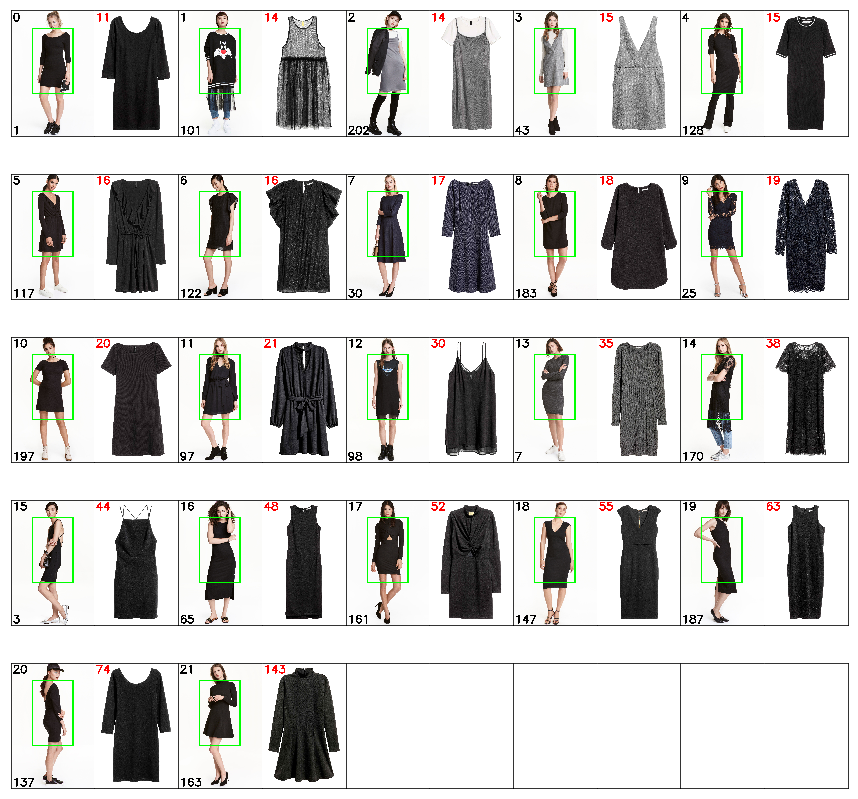

In [200]:
fig = plt.figure(figsize=(15, 15))

# gridspec inside gridspec
outer_grid = gridspec.GridSpec(5, 5, wspace=0.0, hspace=0.0)
for i in range(5*5):
    inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[i], wspace=0.0, hspace=0.0)

    for j in range(2):
        img = np.ones(img_cat_ex.shape)
        if i < len(errors_id_rank):
            if j == 0:
                img = quer_error_per_id[errors_id_rank[i][0]]
            if j == 1:
                img = cat_error_per_id[errors_id_rank[i][0]]
                
            img = img.copy()
            if j == 1:
                img = cv2.putText(img,str(errors_id_rank[i][1]), (50,300), cv2.FONT_HERSHEY_SIMPLEX,fontScale=10, thickness=40,color=(255,0,0))
            if j == 0:
                img = cv2.putText(img,str(i), (50,300), cv2.FONT_HERSHEY_SIMPLEX,fontScale=10, thickness=40,color=(0,0,0))
                img = cv2.putText(img,str(errors_id_rank[i][0]), (50,3400), cv2.FONT_HERSHEY_SIMPLEX,fontScale=10, thickness=40,color=(0,0,0))
                draw_rectangle(img,roi_query,thick=30,color=(0,255,0))
        ax = plt.Subplot(fig, inner_grid[j])
        
        ax.imshow(img)
        ax.set_xticks([])
        ax.set_yticks([])
        fig.add_subplot(ax)

all_axes = fig.get_axes()
    

for ax in all_axes:
    for sp in ax.spines.values():
        sp.set_visible(False)
    if ax.is_first_row():
        ax.spines['top'].set_visible(True)
    if ax.is_last_row():
        ax.spines['bottom'].set_visible(True)
    if ax.is_first_col():
        ax.spines['left'].set_visible(True)
    if ax.is_last_col():
        ax.spines['right'].set_visible(True)

plt.show()